# CIFAR 10
* $32 * 32 $ 픽셀의 5만개의 컬러이미지
* 데이터는 (3, 32, 32)의 크기를 가짐.
* 최종 클래스는 10개의 클래스로 라벨링
  * 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # activation funcion 사용을 위해 import
import torchvision
from torchvision import datasets, transforms # cifar10 데이터 가져오기 위해서 사용.

In [2]:
# gpu설정
device = torch.device('cuda') 

## 데이터셋 가져오기 및 확인

In [3]:
# Normalize 선언
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Cifar10 Dataset
# 학습 데이터 셋 생성. torchvision에 존재하는 CIFAR10 데이터 셋을 다운
train_dataset = datasets.CIFAR10(root='./CIFAR10_data/', # 데이터 셋을 저장할 경로 지정.
                               train=True,           # 데이터 셋을 학습용과 테스트용으로 분리하는 용도로 train =True 면 학습용을 가져온다.
                               transform=transforms.ToTensor(), # 데이터 셋을 저장할 때 Tensor로 변환(0~1사이의 실수형으로 정규화)해서 저장한다.
                               download=True) # 현재 지정된 root에 데이터셋이 없다면 다운로드, 있다면 다운로드하지 않음.
# 테스트 데이터 셋 생성. torchvision에 존재하는 MNIST 데이터 셋을 다운
test_dataset = datasets.CIFAR10(root='./CIFAR10_data/', # 데이터셋을 저장할 경로
                              train=False, # 데이터 셋을 테스트용을 저장하겠다.
                              transform=transforms.ToTensor())

# 배치 크기 지정
batch_size = 64
# 라벨 선언
labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12962648.38it/s]


Extracting ./CIFAR10_data/cifar-10-python.tar.gz to ./CIFAR10_data/


In [5]:
print(train_dataset[0]) # 데이터가 튜플형식으로 사진과, label로 분류되어 있음.
train_dataset[0][0].size()

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0

torch.Size([3, 32, 32])

## 데이터 로더 생성,

In [4]:
# Data Loader (Input Pipeline)
# 앞서 저장한 train_dataset과 test_dataset(텐서로 구성)을 앞서 선언한 batch_size로 불러온다.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True) # train의 경우 과적합을 방지하기 위해서 shuffle을 해줌.

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False) # test의 경우 결과를 출력해야하므로 shufffle을 따로 해줄 필요가 없음.

# 확인
print(train_loader.dataset)
for x_train, y_train in train_loader:
  print(f'x_train 크기 :{x_train.size()}, 형태 : {x_train.type()}') # 지정된 batch크기가 가장 앞에 그리고 이미지 데이터의 크기 
  print(f'y_train 크기 :{y_train.size()}, 형태 : {y_train.type()}') # 지정된 batch의 크기가 출력.
  break # 첫번째 요소에 대해서 출력

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./CIFAR10_data/
    Split: Train
    StandardTransform
Transform: ToTensor()
x_train 크기 :torch.Size([64, 3, 32, 32]), 형태 : torch.FloatTensor
y_train 크기 :torch.Size([64]), 형태 : torch.LongTensor


## 학습할 모델 생성.
* GoolgeNet 과 ResNet이용.

### GoogleNet
![GoogleNet](https://raw.githubusercontent.com/valoxe/image-storage-1/master/research-paper-summary/inception-v1/3.png?token=AMAXSKLECW7TXM42VJERNRS6WMGK2)

* Inception
![inception](https://miro.medium.com/v2/resize:fit:720/format:webp/1*IlMHbOpiOo_bAH2hJziD4A.png)

* 자세한 구조
![GoogleNet](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*NRH0z_K9NlzLvadJfraW9A.png)

* 실제 GoogleNet에서는 사용한 input_shape는 (224,224,3)이므로 이를 완벽하게 원하는대로 사용할 수 없다.
* 자세한 내용은 Going Deeper with Convolutions 이용.

In [ ]:
# 기본 convolution block 생산.
class convblock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super(convblock, self).__init__()
    self.conv= nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
  def forward(self, x):
    x = self.conv(x)
    x = F.relu(x)
    return x

In [ ]:
# 인셉션 설정
# Conv2d 출력의 크기는 ((입력 이미지의 높이 + 2 * 패딩정도 - 필터 크기) / 필터이동 간격(Stride) + 1 )x ((입력 이미지의 너비 + 2 * 패딩정도 - 필터 크기) / 필터이동 간격(Stride) + 1)
class Inception(nn.Module):
  def __init__(self, in_channels, out_1x1, out_3x3_r,out_3x3, out_5x5_r, out_5x5, out_pool_proj):
    super(Inception, self).__init__()
    self.branch1 = convblock(in_channels, out_1x1, kernel_size = 1, stride =1, padding= 0)
    self.branch2 = nn.Sequential(
        convblock(in_channels, out_3x3_r, kernel_size =1, stride=1, padding= 0),
        convblock(out_3x3_r, out_3x3, kernel_size =3, stride =1 , padding = 1)
    )
    self.branch3 = nn.Sequential(
        convblock(in_channels,out_5x5_r, kernel_size =1, stride = 1, padding =0),
        convblock(out_5x5_r, out_5x5, kernel_size =5, stride =1, padding =2)
    )
    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size = 3, stride =1, padding=1, ceil_mode=False),
        convblock(in_channels, out_pool_proj, kernel_size =1, stride=1, padding =0)
    )

  def forward(self, x):
    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)
    #print(branch1.size(),branch2.size(),branch3.size(),x.size(),branch4.size())
    return torch.cat([branch1, branch2, branch3, branch4], 1)      


In [ ]:
# GoogleNet 선언 보다 작게 선언
class GoogleNet(nn.Module):
  def __init__(self, labels = 10):
    super(GoogleNet, self).__init__()
    self.conv1 = convblock(3, 32, kernel_size = 3, stride = 1, padding=1) # 초기 3, 32, 32 -> 32, 32, 32
    self.conv2 = convblock(32, 64, kernel_size = 3, stride = 1, padding=1) # 32, 32, 32 -> 64, 32, 32
    self.inceptiona = Inception(64, 32, 48, 64, 8, 16, 16) # 64, 32, 32 -> 128, 32, 32
    self.inceptionb = Inception(128, 64, 64, 96, 16, 48, 32) # 128, 32, 32 -> 240, 32, 32
    self.pool1 = nn.MaxPool2d(kernel_size =2, stride =2, padding = 0) # 240, 32, 32 -> 240, 16, 16
    self.inceptionc = Inception(240, 64, 64, 128, 12, 32, 32) # 240, 16, 16 -> 256, 16,16
    self.inceptiond = Inception(256, 128, 128, 256, 24, 64, 64) # 512, 16 , 16
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding = 0) # 512, 8, 8
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # 512, 1, 1
    self.dropout = nn.Dropout(p=0.5) # 과접합 방지를 위해서 dropout 50%
    self.fc = nn.Linear(512, labels)  # 마지막 512 -> 10d으로 바꾸기
  def forward(self, x):
    # input size: 3x32x32
    x = self.conv1(x)           # output size: 32x32x32
    x = self.conv2(x)           # output size: 64x32x32
    x = self.inceptiona(x)      # output size: 128x32x32
    x = self.inceptionb(x)      # output size: 240x32x32
    x = self.pool1(x)           # output size: 240x16x16
    x = self.inceptionc(x)      # output size: 256x16x16
    x = self.inceptiond(x)      # output size: 512x16x16
    x = self.pool2(x)           # output size: 512x8x8
    x = self.avgpool(x)         # output size: 512x1x1
    x = x.view(x.size(0), -1)   # output size: 512
    x = self.dropout(x)
    x = self.fc(x)              # output size: 10
    return x


### 학습


In [ ]:
model = GoogleNet(labels =10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # Stochastic Gradient Descent를 optimizer로 생성하고, 학습률은 0.01로 한다.
# momentum을 이용해 이전의 SGD 업데이트 방향성을 반영한다. 보통 0.5~ 0.9로 반영(클수록 더 많이 반영한다)
def train(epoch):
  model.train() # 학습 모드
  train_loss = 0.0 # 학습시 오차 출력을 위해서 선언
  correct = 0 # 얼마나 맞은지 알기 위해 선언
  total =0
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() # optimizer 초기화
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() # 학습 시 
    _, predicted = output.max(1) # 최종 결과는 predicted로 저장
    total += target.size(0) # 총 몇개인지 확인
    correct += predicted.eq(target).sum().item() # 맞으면 1 아니면 0인 tensor로 반환하여 체 배치에서 얼마나 맞았는지 알 수 있다.
  print(f'Epoch : {epoch+1}/{150} Loss : {train_loss/(batch_size):.3f} accuracy : {100*correct/total:.3f}')

def test():
  model.eval() # 학습한 모델을 평가모드로함.(모델의 layer들이 학습되지 않는다.)
  test_loss = 0  # 초기의 loss 지정
  correct = 0  # 초기의 correct 지정
  total = 0 # 정확성 비교를 위해서 사용
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      outputs = model(data) # 예측
      loss = criterion(outputs, target) # loss 계산
      test_loss += loss.item() 
      _, predicted = outputs.max(1)
      total += target.size(0)
      correct += predicted.eq(target).sum().item()
  print('===========================================================================')
  print(f'Test,  Loss : {test_loss/(batch_size):.3f} accuracy : {100*correct/total:.3f}')
  print('===========================================================================')


In [ ]:
for epoch in range(150): # 총 epoch가 150번 학습
  train(epoch)
  model.eval() # 평가모드
  test_loss = 0  # 초기의 loss 지정
  correct = 0  # 초기의 correct 지정
  total = 0 # 정확성 비교를 위해서 사용
  with torch.no_grad(): # 결과 분석이므로 학습 x
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      outputs = model(data) # 예측
      loss = criterion(outputs, target) # loss 계산
      test_loss += loss.item() 
      _, predicted = outputs.max(1)
      total += target.size(0)
      correct += predicted.eq(target).sum().item()
  print('===========================================================================')
  print(f'Test,  Loss : {test_loss/(batch_size):.3f} accuracy : {100*correct/total:.3f}')
  print('===========================================================================')

torch.save(model.state_dict(), '/content/drive/MyDrive/딥러닝 공부/GoogleNet.pth') # 모델 저장

Epoch : 1/150 Loss : 28.121 accuracy : 11.476
Test,  Loss : 5.644 accuracy : 15.870
Epoch : 2/150 Loss : 28.102 accuracy : 13.058
Test,  Loss : 5.636 accuracy : 16.470
Epoch : 3/150 Loss : 27.994 accuracy : 16.946
Test,  Loss : 5.575 accuracy : 17.060
Epoch : 4/150 Loss : 26.526 accuracy : 18.288
Test,  Loss : 5.126 accuracy : 18.470
Epoch : 5/150 Loss : 25.373 accuracy : 19.938
Test,  Loss : 5.009 accuracy : 20.700
Epoch : 6/150 Loss : 25.085 accuracy : 20.464
Test,  Loss : 5.037 accuracy : 21.820
Epoch : 7/150 Loss : 24.791 accuracy : 21.216
Test,  Loss : 4.898 accuracy : 23.510
Epoch : 8/150 Loss : 24.507 accuracy : 22.640
Test,  Loss : 4.835 accuracy : 24.780
Epoch : 9/150 Loss : 24.119 accuracy : 23.136
Test,  Loss : 4.827 accuracy : 24.590
Epoch : 10/150 Loss : 23.524 accuracy : 25.032
Test,  Loss : 4.565 accuracy : 27.320
Epoch : 11/150 Loss : 22.689 accuracy : 27.114
Test,  Loss : 4.396 accuracy : 30.440
Epoch : 12/150 Loss : 22.089 accuracy : 29.018
Test,  Loss : 4.464 accurac

In [ ]:
for epoch in range(30): # 총 epoch가 150번 학습
  train(epoch)
  model.eval() # 평가모드
  test_loss = 0  # 초기의 loss 지정
  correct = 0  # 초기의 correct 지정
  total = 0 # 정확성 비교를 위해서 사용
  with torch.no_grad(): # 결과 분석이므로 학습 x
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      outputs = model(data) # 예측
      loss = criterion(outputs, target) # loss 계산
      test_loss += loss.item() 
      _, predicted = outputs.max(1)
      total += target.size(0)
      correct += predicted.eq(target).sum().item()
  print('===========================================================================')
  print(f'Test,  Loss : {test_loss/(batch_size):.3f} accuracy : {100*correct/total:.3f}')
  print('===========================================================================')

torch.save(model.state_dict(), '/content/drive/MyDrive/딥러닝 공부/GoogleNet.pth') # 모델 저장

Epoch : 1/150 Loss : 4.846 accuracy : 86.000
Test,  Loss : 1.448 accuracy : 80.160
Epoch : 2/150 Loss : 4.807 accuracy : 86.006
Test,  Loss : 1.443 accuracy : 80.350
Epoch : 3/150 Loss : 4.753 accuracy : 85.998
Test,  Loss : 1.562 accuracy : 79.330
Epoch : 4/150 Loss : 4.746 accuracy : 86.328
Test,  Loss : 1.458 accuracy : 80.220
Epoch : 5/150 Loss : 4.745 accuracy : 86.216
Test,  Loss : 1.483 accuracy : 80.000
Epoch : 6/150 Loss : 4.642 accuracy : 86.574
Test,  Loss : 1.541 accuracy : 79.470
Epoch : 7/150 Loss : 4.578 accuracy : 86.564
Test,  Loss : 1.479 accuracy : 80.270
Epoch : 8/150 Loss : 4.510 accuracy : 86.886
Test,  Loss : 1.533 accuracy : 79.770
Epoch : 9/150 Loss : 4.472 accuracy : 86.930
Test,  Loss : 1.467 accuracy : 79.970
Epoch : 10/150 Loss : 4.384 accuracy : 87.246
Test,  Loss : 1.485 accuracy : 80.570
Epoch : 11/150 Loss : 4.358 accuracy : 87.372
Test,  Loss : 1.606 accuracy : 79.290
Epoch : 12/150 Loss : 4.337 accuracy : 87.416
Test,  Loss : 1.495 accuracy : 79.730
E

## RestNet
* Degration 문제 해결  

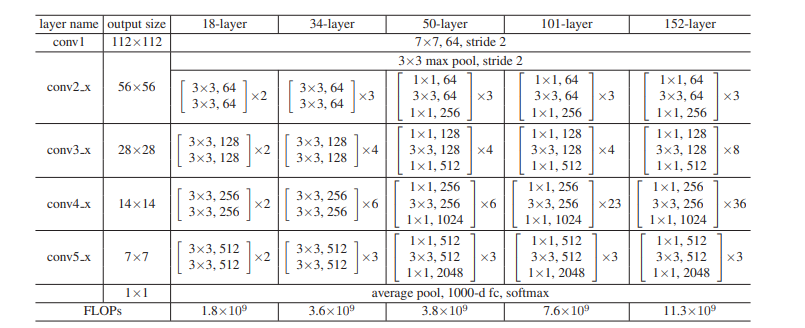

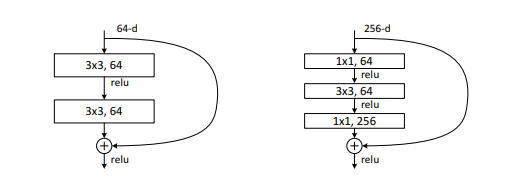

### 학습
* 50 layer 이용.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [34]:
class ResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet50, self).__init__()
        self.resnet50 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=False) # Resnet모델 불러오기
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(1000, num_classes) # resent50의 결과로 batchsize, 1000이 나오므로
        

    def forward(self, x):
        x = self.resnet50(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [38]:
# 모델 선언 및 하이퍼파라미터 선언
model = ResNet50(num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
# weight_decay를 통해 l2 정규화를 이용해 과접합 방지

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [39]:
model = model.to(device)
# momentum을 이용해 이전의 SGD 업데이트 방향성을 반영한다. 보통 0.5~ 0.9로 반영(클수록 더 많이 반영한다)
def train(epoch):
  model.train() # 학습 모드
  train_loss = 0.0 # 학습시 오차 출력을 위해서 선언
  correct = 0 # 얼마나 맞은지 알기 위해 선언
  total =0
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() # optimizer 초기화
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() # 학습 시 
    _, predicted = output.max(1) # 최종 결과는 predicted로 저장
    total += target.size(0) # 총 몇개인지 확인
    correct += predicted.eq(target).sum().item() # 맞으면 1 아니면 0인 tensor로 반환하여 체 배치에서 얼마나 맞았는지 알 수 있다.
  print(f'Epoch : {epoch+1}/{100} Loss : {train_loss/(batch_size):.3f} accuracy : {100*correct/total:.3f}')

def test():
  model.eval() # 학습한 모델을 평가모드로함.(모델의 layer들이 학습되지 않는다.)
  test_loss = 0  # 초기의 loss 지정
  correct = 0  # 초기의 correct 지정
  total = 0 # 정확성 비교를 위해서 사용
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      outputs = model(data) # 예측
      loss = criterion(outputs, target) # loss 계산
      test_loss += loss.item() 
      _, predicted = outputs.max(1)
      total += target.size(0)
      correct += predicted.eq(target).sum().item()
  print(f'Test,  Loss : {test_loss/(batch_size):.3f} accuracy : {100*correct/total:.3f}')
  print('===========================================================================')


In [40]:
for epoch in range(100): # 총 epoch가 150번 학습
  train(epoch)
  test()

torch.save(model.state_dict(), '/content/drive/MyDrive/딥러닝 공부/ResNet.pth') # 모델 저장

Epoch : 1/100 Loss : 28.133 accuracy : 15.240
Test,  Loss : 5.177 accuracy : 22.860
Epoch : 2/100 Loss : 25.249 accuracy : 23.306
Test,  Loss : 4.717 accuracy : 29.400
Epoch : 3/100 Loss : 23.231 accuracy : 30.138
Test,  Loss : 4.363 accuracy : 34.530
Epoch : 4/100 Loss : 21.632 accuracy : 35.046
Test,  Loss : 4.097 accuracy : 38.990
Epoch : 5/100 Loss : 20.348 accuracy : 38.992
Test,  Loss : 3.885 accuracy : 41.450
Epoch : 6/100 Loss : 19.467 accuracy : 41.846
Test,  Loss : 3.769 accuracy : 44.550
Epoch : 7/100 Loss : 18.765 accuracy : 43.978
Test,  Loss : 3.690 accuracy : 45.060
Epoch : 8/100 Loss : 17.982 accuracy : 46.308
Test,  Loss : 3.600 accuracy : 45.810
Epoch : 9/100 Loss : 17.327 accuracy : 48.444
Test,  Loss : 3.582 accuracy : 47.200
Epoch : 10/100 Loss : 16.771 accuracy : 50.262
Test,  Loss : 3.508 accuracy : 48.280
Epoch : 11/100 Loss : 16.245 accuracy : 51.904
Test,  Loss : 3.464 accuracy : 48.930
Epoch : 12/100 Loss : 15.694 accuracy : 53.360
Test,  Loss : 3.427 accurac

KeyboardInterrupt: ignored

## 전이학습

In [41]:
# VGG16 모델 가져오기
model = torchvision.models.vgg16(pretrained=True)

# VGG16 모델의 fully connected layer 수정하기
model.classifier[6] = nn.Linear(4096, 10)

# 모델 학습을 위한 하이퍼파라미터 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# GPU 사용 가능 여부 체크
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 291MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [42]:
def train(epoch):
  model.train() # 학습 모드
  train_loss = 0.0 # 학습시 오차 출력을 위해서 선언
  correct = 0 # 얼마나 맞은지 알기 위해 선언
  total =0
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() # optimizer 초기화
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() # 학습 시 
    _, predicted = output.max(1) # 최종 결과는 predicted로 저장
    total += target.size(0) # 총 몇개인지 확인
    correct += predicted.eq(target).sum().item() # 맞으면 1 아니면 0인 tensor로 반환하여 체 배치에서 얼마나 맞았는지 알 수 있다.
  print(f'Epoch : {epoch+1}/{10} Loss : {train_loss/(batch_size):.3f} accuracy : {100*correct/total:.3f}')

def test():
  model.eval() # 학습한 모델을 평가모드로함.(모델의 layer들이 학습되지 않는다.)
  test_loss = 0  # 초기의 loss 지정
  correct = 0  # 초기의 correct 지정
  total = 0 # 정확성 비교를 위해서 사용
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      outputs = model(data) # 예측
      loss = criterion(outputs, target) # loss 계산
      test_loss += loss.item() 
      _, predicted = outputs.max(1)
      total += target.size(0)
      correct += predicted.eq(target).sum().item()
  print(f'Test,  Loss : {test_loss/(batch_size):.3f} accuracy : {100*correct/total:.3f}')
  print('===========================================================================')


In [43]:
for epoch in range(10): # 총 epoch가 150번 학습
  train(epoch)
  test()
torch.save(model.state_dict(), '/content/drive/MyDrive/딥러닝 공부/transferVGG16.pth')

Epoch : 1/10 Loss : 9.766 accuracy : 72.358
Test,  Loss : 1.381 accuracy : 80.560
Epoch : 2/10 Loss : 5.564 accuracy : 84.384
Test,  Loss : 1.158 accuracy : 83.460
Epoch : 3/10 Loss : 4.085 accuracy : 88.404
Test,  Loss : 1.130 accuracy : 84.420
Epoch : 4/10 Loss : 3.066 accuracy : 91.318
Test,  Loss : 1.173 accuracy : 84.770
Epoch : 5/10 Loss : 2.296 accuracy : 93.526
Test,  Loss : 1.075 accuracy : 85.940
Epoch : 6/10 Loss : 1.657 accuracy : 95.402
Test,  Loss : 1.157 accuracy : 86.720
Epoch : 7/10 Loss : 1.195 accuracy : 96.692
Test,  Loss : 1.181 accuracy : 87.090
Epoch : 8/10 Loss : 0.826 accuracy : 97.700
Test,  Loss : 1.272 accuracy : 86.940
Epoch : 9/10 Loss : 0.696 accuracy : 98.008
Test,  Loss : 1.329 accuracy : 87.160
Epoch : 10/10 Loss : 0.602 accuracy : 98.324
Test,  Loss : 1.412 accuracy : 87.140


In [46]:
# ResNet50 모델 가져오기
model = torchvision.models.resnet50(pretrained=True)

# ResNet50 모델의 fully connected layer 수정하기 마지막 10개의 class에 대한 예측을 위해서 사용.
model.fc = nn.Linear(2048, 10) # 

# 모델 학습을 위한 하이퍼파라미터 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# GPU 사용 가능 여부 체크
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
for epoch in range(10): # 총 epoch가 150번 학습
  train(epoch)
  test()
torch.save(model.state_dict(), '/content/drive/MyDrive/딥러닝 공부/transferResNet50.pth')

Epoch : 1/10 Loss : 11.867 accuracy : 66.338
Test,  Loss : 1.522 accuracy : 78.930
Epoch : 2/10 Loss : 6.223 accuracy : 82.480
Test,  Loss : 1.323 accuracy : 81.970
Epoch : 3/10 Loss : 4.179 accuracy : 88.256
Test,  Loss : 1.330 accuracy : 82.330
Epoch : 4/10 Loss : 2.817 accuracy : 91.974
Test,  Loss : 1.452 accuracy : 82.260
Epoch : 5/10 Loss : 2.119 accuracy : 93.950
Test,  Loss : 1.507 accuracy : 82.730
Epoch : 6/10 Loss : 1.599 accuracy : 95.436
Test,  Loss : 1.529 accuracy : 83.460
Epoch : 7/10 Loss : 1.163 accuracy : 96.760
Test,  Loss : 1.646 accuracy : 82.870
Epoch : 8/10 Loss : 0.962 accuracy : 97.320
Test,  Loss : 1.706 accuracy : 83.630
Epoch : 9/10 Loss : 0.705 accuracy : 98.022
Test,  Loss : 1.761 accuracy : 83.180
Epoch : 10/10 Loss : 0.597 accuracy : 98.402
Test,  Loss : 1.774 accuracy : 83.860
